# Incremental Anomaly Detection
In this notebook, we attempt to use `creme`'s anomaly detection suit on a stream of highly imbalanced traffic. Again, we are emulating a positive class fraction of .17%

In [1]:
import string
import os
import pickle


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

from creme import stream
from creme import model_selection
from creme import compose
from creme import feature_extraction
from creme import linear_model
from creme import metrics
from creme import preprocessing
from creme import stats
from creme import anomaly

In [2]:
train_attack_types = pd.read_csv("datasets/training_attack_types.txt", delimiter=" ", header=None, names= ["attack_type", "attack_category"])

In [3]:
target = "back"
train_attack_types.loc[train_attack_types["attack_type"]==target, "attack_category"].values[0]

'dos'

In [4]:
cols = list(pd.read_csv("datasets/kddcup.names.txt", skiprows=1, header=None)[0].map(lambda x: str(x).split(":")[0]).values)
cols.append("label")


reduced_cols = cols[:9]
reduced_cols.append("label")

reduced_cols

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'label']

In [5]:
train = pd.read_csv("datasets/kddcup.data.corrected.txt", header=None, names=cols)

In [6]:
train = train[reduced_cols].copy()

In [7]:
test = pd.read_csv("datasets/corrected.txt", header=None, names=cols)

In [8]:
test = test[reduced_cols].copy()

In [9]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,tcp,http,SF,215,45076,0,0,0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,normal.
4,0,tcp,http,SF,239,486,0,0,0,normal.


In [10]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,udp,private,SF,105,146,0,0,0,normal.
1,0,udp,private,SF,105,146,0,0,0,normal.
2,0,udp,private,SF,105,146,0,0,0,normal.
3,0,udp,private,SF,105,146,0,0,0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,snmpgetattack.


# Preprocessing

## Process the label column
We want to remove the period. Then we want to generate three label columns:

In [11]:
train["label"] = train["label"].map(lambda x: x.split(".")[0])
test["label"] = test["label"].map(lambda x: x.split(".")[0])

### Binary label (normal/malicious)

In [12]:
train["label_binary"] = train["label"].map(lambda x: 0 if x=="normal" else 1)
test["label_binary"] = test["label"].map(lambda x: 0 if x=="normal" else 1)

In [13]:
test["label_binary"].value_counts()

1    250436
0     60593
Name: label_binary, dtype: int64

In [14]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

In [15]:
# X = pd.get_dummies(train, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary"])
train_shuffled = train.sample(frac=1).reset_index(drop=True)

# Subsampling


In [16]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

In [17]:
972781*0.0017

1653.7277

We'll sample 1500 instances from the positive class, shuffle it in with all of the negative class. 

In [18]:
train.shape

(4898431, 11)

In [19]:
test.shape

(311029, 11)

In [20]:
subsampled_malware = train.loc[train["label_binary"]==1].sample(1500)
background = train.loc[train["label_binary"]==0].iloc[250:]
warmup = train.loc[train["label_binary"]==0].iloc[:250]
df = pd.concat([subsampled_malware, background])

In [21]:
df = df.sample(frac=1).reset_index(drop=True)

In [27]:
background["service"].value_counts()

http        618796
smtp         95371
private      73853
domain_u     57773
other        56520
ftp_data     38093
urp_i         5375
finger        5017
ntp_u         3833
ftp           3821
eco_i         3768
ecr_i         3456
auth          2328
telnet        2227
pop_3          922
IRC            520
time           509
urh_i          148
X11            129
domain          38
red_i            9
tim_i            7
ssh              7
shell            5
imap4            3
tftp_u           3
Name: service, dtype: int64

# Anomaly Detection with HalfSpaceTrees
## Data stream
Here we will build our data stream

In [22]:
datastream = stream.iter_pandas(df.drop(columns=["label_binary", "label"]), df["label_binary"])
warmup_stream = stream.iter_pandas(warmup.drop(columns=["label_binary", "label"]), warmup["label_binary"])
# teststream = stream.iter_pandas(holdout.drop(columns=["label_binary", "label"]), holdout["label_binary"]

## Pipeline
We will scale and one-hot-encode.

In [23]:
train.dtypes

duration           int64
protocol_type     object
service           object
flag              object
src_bytes          int64
dst_bytes          int64
land               int64
wrong_fragment     int64
urgent             int64
label             object
label_binary       int64
dtype: object

In [24]:
cols_string = [col for col,col_type in zip(train.columns[:-2], train.dtypes[:-2]) if col_type == "object"]

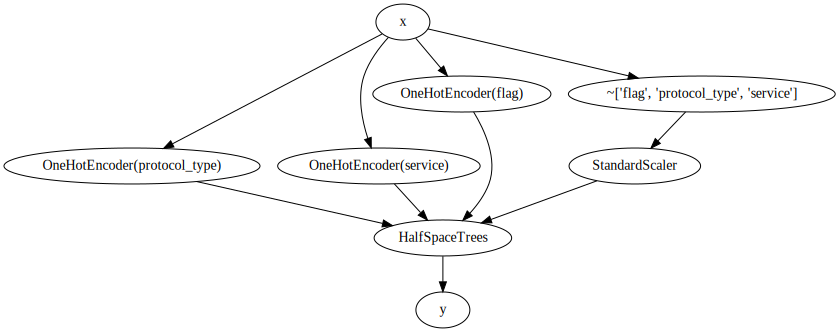

In [25]:
string_processor = (compose.TransformerUnion([preprocessing.OneHotEncoder(col) for col in cols_string]))
num_processor = compose.Blacklister(*cols_string)|preprocessing.StandardScaler()
model =  num_processor + string_processor
model |= anomaly.HalfSpaceTrees(scale=False)
model.draw()

In [26]:
df.shape

(974031, 11)

In [69]:
# Run
counter=0
for x,y in datastream:
    if counter%10000 == 0:
        print(f"Current iteration: {counter}")

    y_pred = model.predict_one(x)
    if y_pred == y == 1:
        print("gottem")
    
#     rocauc.update(y, y_pred)
    cm.update(y, y_pred)
    recall.update(y, y_pred)
    f1.update(y, y_pred)
    precision.update(y, y_pred)
    
    model.fit_one(x, y)
    counter+=1
# print(rocauc)
# print(cm)
print(recall)
print(f1)
print(precision)

Current iteration: 0
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Current iteration: 60000
Current iteration: 70000
Current iteration: 80000
Current iteration: 90000
Current iteration: 100000
Current iteration: 110000
Current iteration: 120000
Current iteration: 130000
Current iteration: 140000
Current iteration: 150000
Current iteration: 160000
Current iteration: 170000
Current iteration: 180000
Current iteration: 190000
Current iteration: 200000
Current iteration: 210000
Current iteration: 220000
Current iteration: 230000
Current iteration: 240000
Current iteration: 250000
Current iteration: 260000
Current iteration: 270000
Current iteration: 280000
Current iteration: 290000
Current iteration: 300000
Current iteration: 310000
Current iteration: 320000
Current iteration: 330000
Current iteration: 340000
Current iteration: 350000
Current iteration: 360000
Current iteration: 370000
Current iteration: 380000


In [75]:
cm

                   0         1
         0  972527.0         0
         1    1500.0         0

We have failed to successfully classify a single instance of malicious traffic!

In [51]:
# warmup_stream = stream.iter_pandas(warmup.drop(columns=["label_binary", "label"]))
# # Warmup
# for x in warmup_stream:
#     print(x)
#     model.fit_one(x)

In [57]:
warmup_stream = stream.iter_pandas(warmup.drop(columns=["label_binary", "label", "protocol_type", "service", "flag"]))
datastream = stream.iter_pandas(df.drop(columns=["label_binary", "label"]), df["label_binary"])
hst = anomaly.HalfSpaceTrees()
for x in warmup_stream:
#     print(x[0])
    hst = hst.fit_one(x[0])
    
for x, y in datastream:
    print(x)
    print(y)
    

C:\Users\AzNsAnTaGiN\Anaconda3\lib\site-packages\creme\preprocessing\scale.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return a / b


{'duration': 0, 'protocol_type': 'udp', 'service': 'domain_u', 'flag': 'SF', 'src_bytes': 33, 'dst_bytes': 93, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 328, 'dst_bytes': 259, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'ftp_data', 'flag': 'SF', 'src_bytes': 10044, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 207, 'dst_bytes': 294, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'icmp', 'service': 'urp_i', 'flag': 'SF', 'src_bytes': 78, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 199, 'dst_bytes': 4962, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'udp', 'service': 'privat

{'duration': 0, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 145, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 238, 'dst_bytes': 1481, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 14, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 145, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 147, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 232, 'dst_bytes': 2507, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'ftp_data', 'flag': 'SF', 'src_bytes': 637, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service':

0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 205, 'dst_bytes': 1859, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 203, 'dst_bytes': 7243, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 212, 'dst_bytes': 434, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 224, 'dst_bytes': 506, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 7030, 'protocol_type': 'udp', 'service': 'other', 'flag': 'SF', 'src_bytes': 147, 'dst_bytes': 105, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'smtp', 

{'duration': 0, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 147, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 2000, 'protocol_type': 'udp', 'service': 'other', 'flag': 'SF', 'src_bytes': 147, 'dst_bytes': 105, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'smtp', 'flag': 'SF', 'src_bytes': 4409, 'dst_bytes': 333, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'ftp_data', 'flag': 'SF', 'src_bytes': 192, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 224, 'dst_bytes': 1227, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 291, 'dst_bytes': 1694, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': '

{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 308, 'dst_bytes': 446, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'ftp_data', 'flag': 'SF', 'src_bytes': 10272, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 217, 'dst_bytes': 24716, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 1, 'protocol_type': 'tcp', 'service': 'smtp', 'flag': 'SF', 'src_bytes': 881, 'dst_bytes': 334, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 214, 'dst_bytes': 22856, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 

{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 230, 'dst_bytes': 10392, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 204, 'dst_bytes': 21953, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'ftp_data', 'flag': 'SF', 'src_bytes': 879, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 325, 'dst_bytes': 6943, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 295, 'dst_bytes': 7903, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 209, 'dst_bytes': 1459, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'htt

0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'ftp_data', 'flag': 'SF', 'src_bytes': 8173, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'smtp', 'flag': 'SF', 'src_bytes': 905, 'dst_bytes': 361, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 15, 'protocol_type': 'tcp', 'service': 'smtp', 'flag': 'SF', 'src_bytes': 1125, 'dst_bytes': 331, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 2715, 'protocol_type': 'udp', 'service': 'other', 'flag': 'SF', 'src_bytes': 147, 'dst_bytes': 105, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'udp', 'service': 'domain_u', 'flag': 'SF', 'src_bytes': 27, 'dst_bytes': 27, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 14, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 147, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'servic

0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 209, 'dst_bytes': 9921, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 228, 'dst_bytes': 774, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 221, 'dst_bytes': 2840, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 380, 'dst_bytes': 370, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 146, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'other', 

0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 324, 'dst_bytes': 2638, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 145, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 255, 'dst_bytes': 496, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 374, 'dst_bytes': 10951, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'fl

0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 306, 'dst_bytes': 392, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 243, 'dst_bytes': 3640, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 302, 'dst_bytes': 12922, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 288, 'dst_bytes': 2153, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 281, 'dst_bytes': 7094, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', '

0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 233, 'dst_bytes': 2507, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 331, 'dst_bytes': 307, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 294, 'dst_bytes': 8760, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF', 'src_bytes': 223, 'dst_bytes': 397, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'udp', 'service': 'private', 'flag': 'SF', 'src_bytes': 105, 'dst_bytes': 147, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', 'flag': 'REJ', 'src_bytes': 0, 'dst_bytes': 0, 'land': 0, 'wrong_fragment': 0, 'urgent': 0}
0
{'duration': 0, 'protocol_type': 'tcp', 'service': 'http', '

KeyboardInterrupt: 

This is a disaster! Not a single malicious instance is correctly classified.

# Anomaly detection in creme

Below we will see how well `creme`'s anomaly detector works.

In [ ]:
datastream = stream.iter_pandas(df.drop(columns=["label_binary", "label"]), df["label_binary"])

In [ ]:
# [model.predict_one(x) for x,y in teststream]    

In [ ]:
teststream = stream.iter_pandas(holdout.drop(columns=["label_binary", "label"]), holdout["label_binary"])
y_preds = [model.predict_one(x)for x,y in teststream]

    if counter%10 == 0:
        print(f"Current iteration: {counter}")
#         print(f"Current confusion matrix: {cm}")
        print(f"Current recall: {recall}")
        print(f"Current f1: {f1}")
        print(f"Current precision: {precision}")
        print()
    y_pred= model.predict_one(x)
    counter += 1

In [ ]:
X = [0.5, 0.45, 0.43, 0.44, 0.445, 0.45, 0.0]
hst = anomaly.HalfSpaceTrees(
    n_trees=5,
    tree_height=3,
    window_size=3,
    scale=False,
    seed=42
)
for x in X[:3]:
    hst = hst.fit_one({'x': x})  # Warming up

for x in X:
    features = {'x': x}
    hst = hst.fit_one(features)
    print(f'Anomaly score for {x:.3f}: {hst.score_one(features)}')